In [0]:
import numpy as np
from skimage import img_as_float
from skimage.color import rgb2lab
from skimage.segmentation import slic
from scipy.spatial.distance import cdist
import cv2
from matplotlib import pyplot as plt
# from google.colab.patches import cv2_imshow
#----------------------------tunable inputs-------------------------------------------
uniq_sigma = 1
dist_sigma = 200
k=5.5
alpha=0.033
beta=0.033
nsegments=1000
#-----------------------------custom functions--------------------------
def gaussian_weight(array, sigma):
        weight = np.exp(-cdist(array, array) ** 2 / (2 * sigma ** 2))
        weight /= weight.sum(axis=1)[:, None]
        return weight

def gaussian_weight2(array1, array2, alpha, beta):
        weight = np.exp((-0.5*(alpha*cdist(array1, array1)**2 +beta*cdist(array2,array2)**2))/(2 * 20.0 ** 2))
        weight /= weight.sum(axis=1)[:, None]
        return weight

def saliencyfilter(image):
#-------------------------------abstraction--------------------------
    nrgb = img_as_float(image)
    lab = rgb2lab(nrgb)
    nlab = (lab + np.array([0, 128, 128])) / np.array([100, 255, 255])

    # generate superpixels
    superpixels = slic(lab, nsegments,enforce_connectivity=True, compactness=30.0,convert2lab=False)
    n_segments = superpixels.max() + 1

    # construct position matrix
    max_y, max_x = np.array(superpixels.shape) - 1
    x = np.linspace(0, max_x, image.shape[1]) / max_x
    y = np.linspace(0, max_y, image.shape[0]) / max_y
    position = np.dstack((np.meshgrid(x, y)))

    # compute mean color and position
    mean_lab = np.zeros((n_segments, 3))
    mean_rgb = np.zeros((n_segments, 3))
    mean_position = np.zeros((n_segments, 2))
    for superpixel in np.unique(superpixels):
            mask = superpixels == superpixel
            mean_lab[superpixel, :] = nlab[mask, :].mean(axis=0)
            mean_rgb[superpixel, :] = nrgb[mask, :].mean(axis=0)
            mean_position[superpixel, :] = position[mask, :].mean(axis=0)

#------------------------------uniqueness-------------------------------
    weight0= gaussian_weight(mean_position,uniq_sigma)
    uniqueness = (cdist(mean_rgb,mean_rgb) ** 2 * weight0).sum(axis=1)
    #normalise
    uniqueness=(uniqueness-uniqueness.min()) / (uniqueness.max() -uniqueness.min() + 1e-13)

#-------------------------------distribution----------------------------
    weight1= gaussian_weight(mean_lab,dist_sigma)
    mu = np.dot(weight1, mean_position)
    distribution = np.einsum('ij,ji->i', weight1, cdist(mean_position, mu) ** 2)
    #normalise
    distribution=(distribution-distribution.min()) / (distribution.max() -distribution.min() + 1e-13)

#-------------------------------salency-------------------------------
    saliency = uniqueness * np.exp(-k * distribution)
    weight2= gaussian_weight2(mean_rgb, mean_position,alpha,beta)
    weighted_saliency= np.dot(weight2, saliency)
    #normalise
    weighted_saliency=(weighted_saliency-weighted_saliency.min())/(weighted_saliency.max()-weighted_saliency.min()+ 1e-13)

#--------------------------------result-------------------------------
    result = np.zeros(image.shape[:2])
    for superpixel in np.unique(superpixels):
            mask = superpixels == superpixel
            result[mask] =saliency[superpixel]
    plt.imshow(result)
    return result

def gaus_pyrmd(image,i):
    layer=image.copy()
    for j in range(i): 
        layer = cv2.pyrDown(layer)
        result=cv2_imshow(layer)
    return result,i



input_image


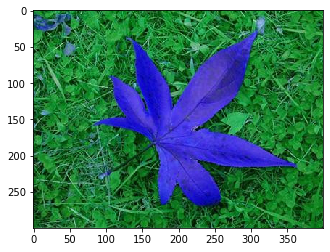

Result of saliency filter


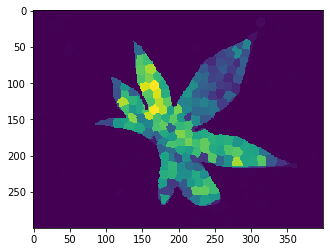

In [31]:
        #--giving input--# 
image=cv2.imread('leaf.jpg')
print('input_image')
plt.imshow(image)
plt.show()
print('Result of saliency filter')
saliencyfilter(image)     
plt.show()